In [19]:
### Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf 
from statsmodels.tsa.arima.model import ARIMA
from numpy import log 
from pylab import rcParams
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('fivethirtyeight')

In [20]:
### Import the Stock Info

ticker = 'GOOG'
start_date = '2018-1-1'

data = yf.Ticker(ticker)
# Fetch historical data starting from the specified start_date
history = data.history(start = start_date)
df = pd.DataFrame(history)
# Reset index to make headings in the same row
df.reset_index(inplace = True)
# Convert the date column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])
# Extract only the date part
df['Date'] = df['Date'].dt.date
# Drop 'Dividends' and 'Stock Splits' columns
#df.drop(['Dividends', 'Stock Splits'], axis = 1)

#date = df['Date']

df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-01-02,52.417000,53.347000,52.261501,53.250000,24752000,0.0,0.0
1,2018-01-03,53.215500,54.314499,53.160500,54.124001,28604000,0.0,0.0
2,2018-01-04,54.400002,54.678501,54.200100,54.320000,20092000,0.0,0.0
3,2018-01-05,54.700001,55.212502,54.599998,55.111500,25582000,0.0,0.0
4,2018-01-08,55.111500,55.563499,55.081001,55.347000,20952000,0.0,0.0


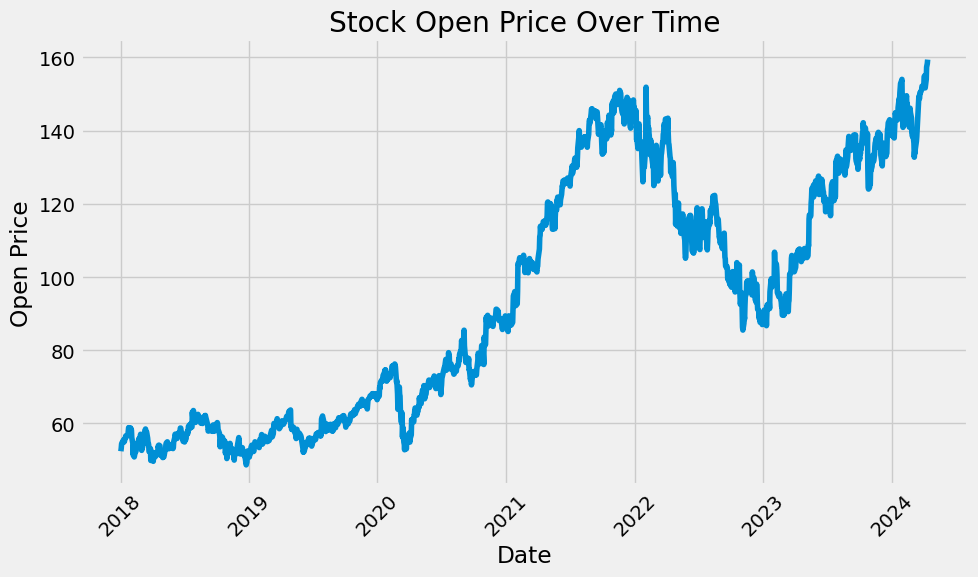

In [21]:
### Plot Data
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Open'])
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Stock Open Price Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

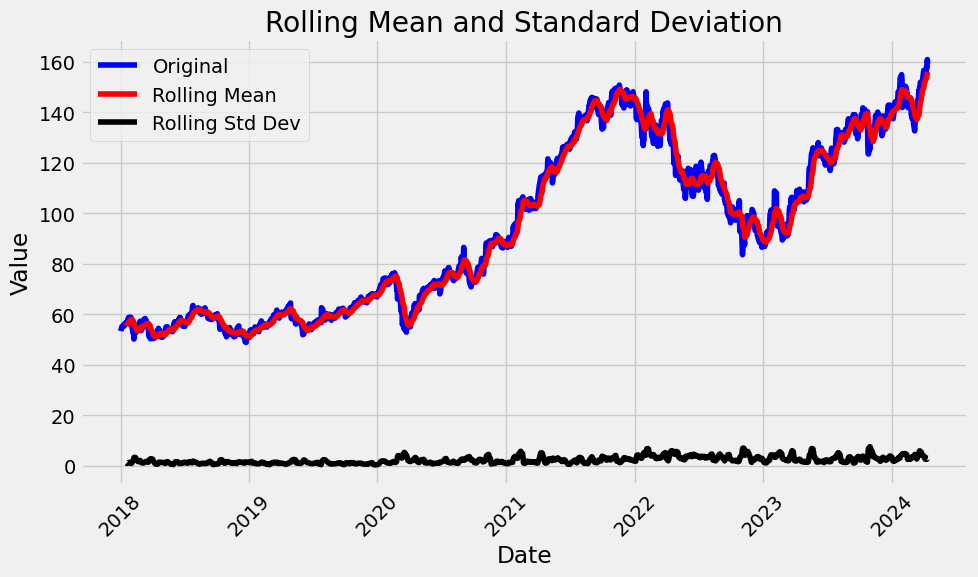

Results of Dickey-Fuller Test
ADF Statistic: -0.3260697727765408
p-value: 0.9217300578237816
Number of Lags Used: 9
Number of Observations Used: 1570
Critical Values:
   1%: -3.4345219897741357
   5%: -2.8633826834772953
   10%: -2.5677510122114486
Maximized Information Criterion (AIC): 6397.55764859723
Since the p value of: 0.9217 > 0.05, we fail to reject the null hypothesis and conclude the data is non-stationary


In [22]:
### Perform Dickey-Fuller Test
'''
The ADF (Augmented Dickey-Fuller) test will allow us to determine the presence of unit root in the series, 
and help to understand if the series is stationary or not.

If the p-value < 0.05 (significance level), we reject the null hypothesis and infer the series is stationary
'''
def adf_test(df_column, date_col):
    result = adfuller(df_column.dropna())

    # Convert 'Date' column to datetime format
    date_col = pd.to_datetime(date_col)

    #Determing rolling statistics
    rolmean = df_column.rolling(12).mean()
    rolstd = df_column.rolling(12).std()
    # Plot rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(date_col, df_column, color='blue', label='Original')
    plt.plot(date_col, rolmean, color='red', label='Rolling Mean')
    plt.plot(date_col, rolstd, color='black', label='Rolling Std Dev')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("Results of Dickey-Fuller Test")
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Number of Lags Used:', result[2])
    print('Number of Observations Used:', result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    print('Maximized Information Criterion (AIC):', result[5])

    p_val = result[1]
    if p_val < 0.05:
        print(f'Since the p value of: {round(p_val, 4)} < 0.05, we reject the null hypothesis and conclude the data is stationary')
    else:
        print(f'Since the p value of: {round(p_val, 4)} > 0.05, we fail to reject the null hypothesis and conclude the data is non-stationary')

# Assuming 'df' is your DataFrame
df_close = df['Close']
date_col = df['Date']
adf_test(df_close, date_col)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


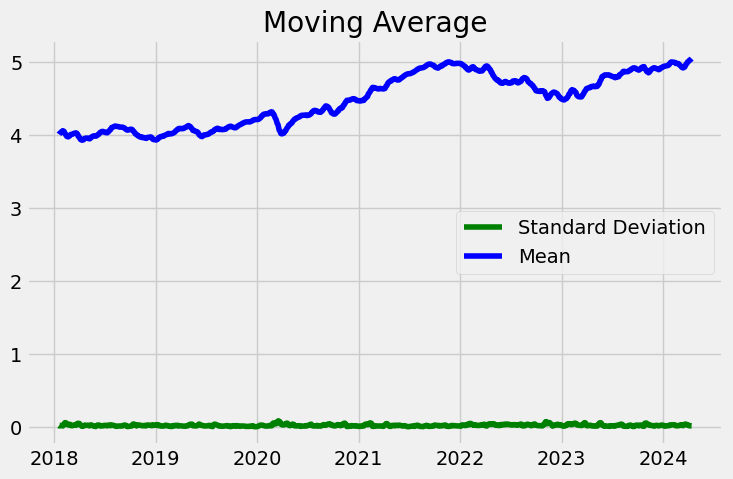

In [23]:
### Eliminate Trend
''' 
Since the data is not stationary, we must eliminate the trend in the data
'''
rcParams['figure.figsize'] = 8, 5
# Take the Log of the series to reduce the magnitude of the values and reduce the rising trend in the series
df_log = np.log(df_close)
''' 
Next compute the rolling average by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series
'''
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc = 'best')
plt.title('Moving Average')
plt.plot(df['Date'], std_dev, color = "green", label = 'Standard Deviation')
plt.plot(df['Date'], moving_avg, color = "blue", label = 'Mean')
plt.legend()
plt.show()

In [24]:
### Re-Test ADF for Stationary Data Verification



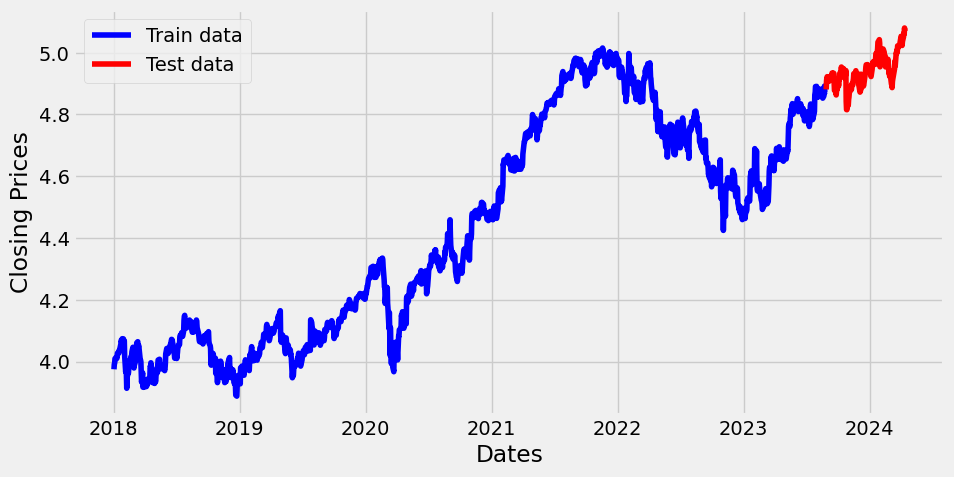

In [25]:
### Split data into Train and Test
n = len(df)
n_train = int(0.9 * n)
train_data, test_data = df_log[:n_train], df_log[n_train:]

# Plot Train and Test Data
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df['Date'][:len(train_data)], train_data, 'blue', label='Train data')
plt.plot(df['Date'][len(train_data):], test_data, 'red', label='Test data')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7107.818, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7116.285, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7116.566, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7108.373, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7114.788, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7114.729, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7113.616, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7116.825, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-7114.990, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-7114.950, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7116.578, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-7113.358, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.573 seconds
                               SARIMAX Results                              

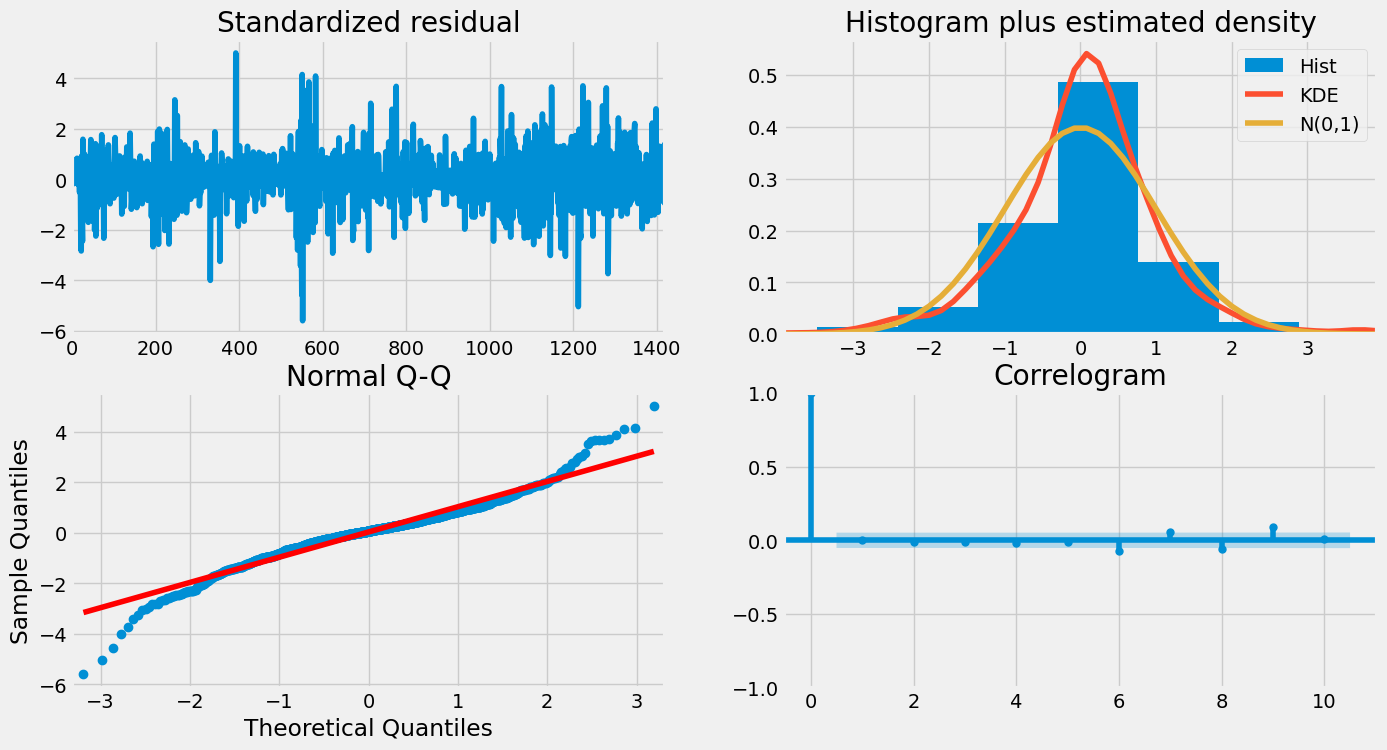

In [26]:
### Construct Auto ARIMA Function to calculate Optimal Order 

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [27]:
### Construct ARIMA Model and Forecast
# Build ARIMA Model
ARIMA_model = ARIMA(train_data, order = (0, 2, 1))  # ARIMA(p, d, q) order
fitted = ARIMA_model.fit()

# Forecast
forecast_steps = 316 # Size of Test Data Set
forecast = fitted.forecast(steps=forecast_steps, alpha=0.05)
conf = fitted.get_forecast(steps=forecast_steps).conf_int()  # Get confidence interval
print(forecast)
#print(conf)

1422    4.873482
1423    4.874136
1424    4.874789
1425    4.875443
1426    4.876097
          ...   
1733    5.076788
1734    5.077442
1735    5.078096
1736    5.078749
1737    5.079403
Name: predicted_mean, Length: 316, dtype: float64


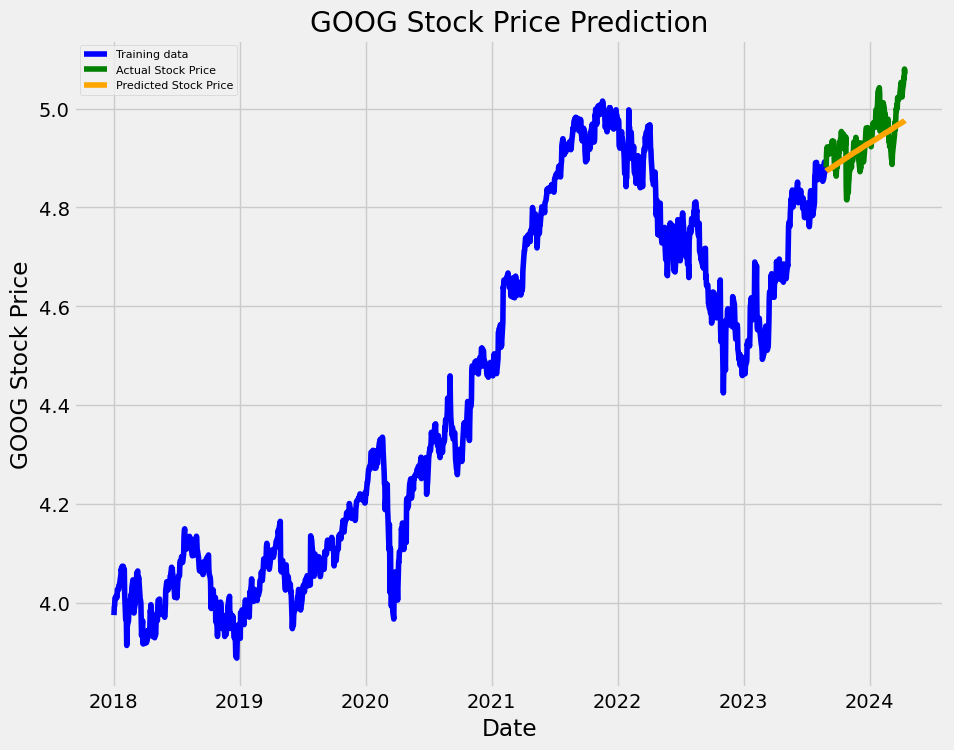

In [28]:
### Plotting Function
# Extract lower and upper bounds from the conf DataFrame
lower_series = conf['lower Close']
upper_series = conf['upper Close']

# Make as pandas series with matching index
fc_series = pd.Series(forecast, index=test_data.index)

# Plot
plt.figure(figsize=(10, 8), dpi=100)
plt.plot(df['Date'][:len(train_data)], train_data, color = 'blue', label = 'Training data')
plt.plot(df['Date'][len(train_data):len(train_data) + len(test_data)], test_data, color = 'green', label = 'Actual Stock Price')
plt.plot(df['Date'][len(train_data):len(train_data) + len(test_data)], fc_series, color = 'orange', label = 'Predicted Stock Price')
#plt.fill_between(df['Date'][len(train_data):len(train_data) + len(test_data)], lower_series, upper_series, color='k', alpha=.10) 
plt.title('GOOG Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('GOOG Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

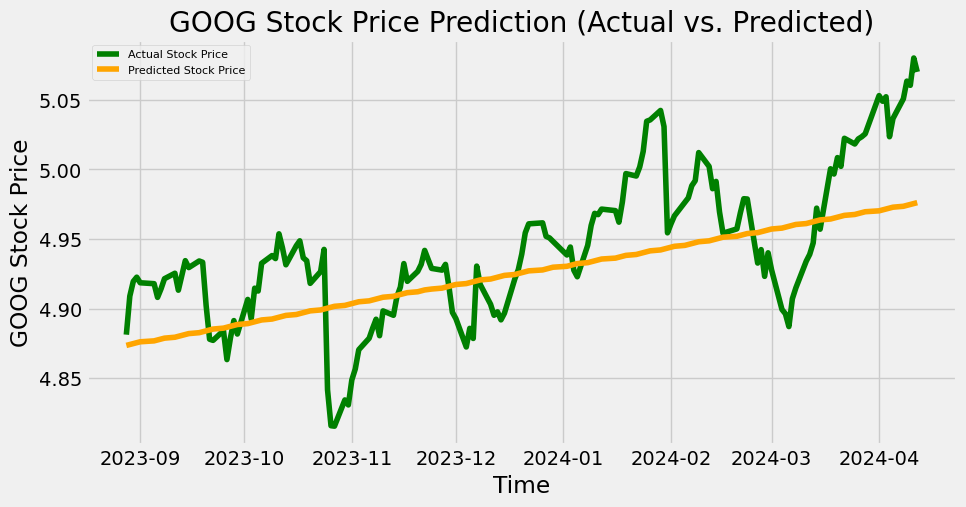

In [29]:
### Plot Actual and Predicted (Zoom In)
plt.figure(figsize = (10, 5), dpi = 100)
plt.plot(df['Date'][len(train_data):len(train_data) + len(test_data)], test_data, color = 'green', label = 'Actual Stock Price')
plt.plot(df['Date'][len(train_data):len(train_data) + len(test_data)], fc_series, color = 'orange', label = 'Predicted Stock Price')
plt.title('GOOG Stock Price Prediction (Actual vs. Predicted)')
plt.xlabel('Time')
plt.ylabel('GOOG Stock Price')
plt.legend(loc='upper left', fontsize = 8)
plt.show()
